# Depth Reconstruction with Deep Neural Networks - Exercise

In this exercise we will learn how to implement a network to perform depth reconstruction from a single image, following the seminal work of Eigen et al \[2014, 2015\].
* https://openaccess.thecvf.com/content_iccv_2015/papers/Eigen_Predicting_Depth_Surface_ICCV_2015_paper.pdf
* https://arxiv.org/pdf/1406.2283.pdf

We will work with the [KITTI](http://www.cvlibs.net/datasets/kitti/eval_scene_flow.php?benchmark=stereo) dataset for training data. We will see how to load the data, augment it and wrap it for usage in Tensorflow.

Load and import some required packages:

In [1]:
!pip3 install -U tensorflow-addons scikit-image albumentations

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Requirement already up-to-date: tensorflow-addons in d:\anaconda\lib\site-packages (0.14.0)
Requirement already up-to-date: scikit-image in d:\anaconda\lib\site-packages (0.18.2)
Requirement already up-to-date: albumentations in d:\anaconda\lib\site-packages (1.0.3)


In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers
import skimage.measure
import albumentations as A
import pandas as pd

## Data

Obtain the depth reconstruction dataset from KITTI:

In [6]:
Get-$3Object -BucketName "avg-kitti" -Key "data"

'[[' is not recognized as an internal or external command,
operable program or batch file.
'[[' is not recognized as an internal or external command,
operable program or batch file.


Very quick verification that the data is valid:

In [4]:
kittiL = cv2.imread('training/image_2/000001_10.png')[:,:,::-1] #OpenCV读取图像
kittiDL = skimage.measure.block_reduce(cv2.imread('training/disp_noc_0/000001_10.png', 0), (8, 8),np.max) #通过对局部块应用函数来下采样图像，然后使用maxpooling。
#什么是下采样：解决数据分布不均衡的下采样的目的就从多数集中选出一部分数据与少数集重新组合成一个新的数据集。

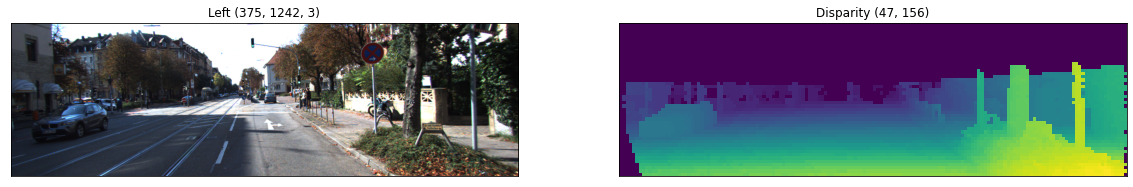

In [5]:
fig = plt.figure(figsize=(20,6))
plt.subplot(121),plt.imshow(kittiL),plt.title(f'Left {kittiL.shape}'); #绘制出左相机的视图
plt.subplot(122),plt.imshow(kittiDL),plt.title(f'Disparity {kittiDL.shape}');#绘制出视差图
plt.setp(fig.get_axes(), xticks=[], yticks=[]);#plt.setp是一个辅助函数.它为艺术家列表设置属性(因此得名).因此plt.setp(标签,旋转= 45)

#### Input Size 
Since we use factor-2 convolutions, we will adjust the resultions of the images to multiples of 2: (192, 640) and (48, 160). These are very close approximations of the real uniform aspect-preserving scale of the data at (192, 636) and (48, 159).

This will allow us to chain many convolutions without risk of fractional pixels.

## Building a data loading & augmentation pipeline

To train the model efficiently, e.g. on a GPU, it's recommended to build a data loading pipeline, so that different parts (like resizing, augmenting) can be accelerated on the GPU.

We provided the dataset creation and augmentation code. Review the code to understand what it does.

Tensorflow provide a very good article on data augmentation: https://www.tensorflow.org/tutorials/images/data_augmentation#apply_augmentation_to_a_dataset

In [6]:
list_ds = tf.data.Dataset.list_files('training/image_2/*_10.png') #加载了一堆左视图的图片
#下面的函数应该是一系列对原始图像的处理，放到了一个pipeline当中
def process_path(file_path, seed):
    parts = tf.strings.split(file_path, os.sep) #输入是list格式，输出是一个SparseTensorValue对象
    label_file = tf.strings.join([parts[0], 'disp_noc_0', parts[2]], os.sep) 

    # Make a new seed so that random transformation is consistent between image
    # and label depth map
    new_seed = tf.random.experimental.stateless_split(seed, num=1)[0, :]
   #以下处理视图
    image = tf.io.read_file(file_path)  #读取
    image = tf.image.decode_png(image)  
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [192, 640])
    image = tf.image.stateless_random_brightness(image, max_delta=0.3, seed=new_seed)
    image = tf.clip_by_value(image, 0, 1)
    image = tf.image.stateless_random_flip_left_right(image, seed=seed)
    image.set_shape((192, 640, 3))  #这里已经reshape了
    #以下处理视差图
    disp = tf.io.read_file(label_file)
    disp = tf.image.decode_png(disp)
    disp = tf.image.convert_image_dtype(disp, tf.float32)
    disp = tf.nn.max_pool2d(tf.expand_dims(disp, 0), (8, 8), 8, 'VALID')
    disp = tf.image.stateless_random_flip_left_right(disp, seed=seed)
    disp = tf.image.flip_left_right(disp)
    disp = tf.image.resize(disp, size=(48, 160))
    disp = tf.squeeze(disp)
    disp = disp * 255.0
    disp.set_shape((48, 160))

    rot_factor = tf.random.uniform(shape=[], minval=-7.0, maxval=7.0, dtype=tf.float32)
    angle = np.pi/180*rot_factor
    image = tfa.image.rotate(image, angle, fill_mode='nearest')
    disp = tfa.image.rotate(disp, angle, fill_mode='nearest')

    return image, disp


counter = tf.data.experimental.Counter()
train_ds = tf.data.Dataset.zip((list_ds, (counter, counter)))
validation_files = train_ds.take(10)
train_ds = train_ds.skip(10)

labeled_ds = train_ds.map(process_path, num_parallel_calls=4)
labeled_ds = labeled_ds.batch(32, drop_remainder=True).prefetch(buffer_size=32).repeat()

val_ds = validation_files.map(process_path).batch(5)

Instructions for updating:
Use `tf.data.Dataset.scan(...) instead


Let's test the `tf.Dataset` pipeline:

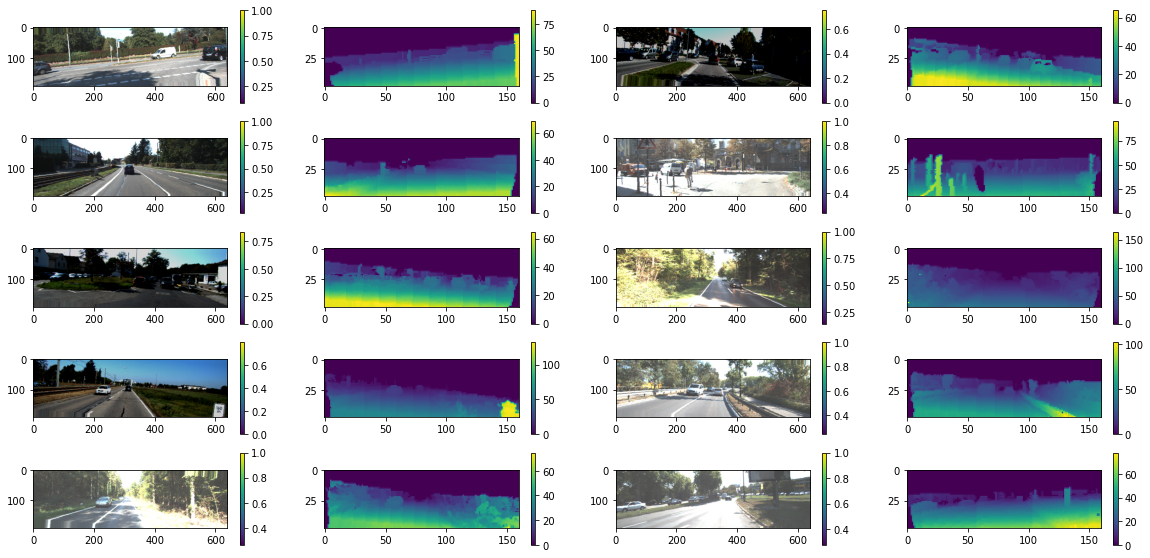

In [7]:
fig= plt.figure(figsize=(20, 20))
for i_f, f in enumerate(labeled_ds.take(1)):
    for i in range(10):
        plt.subplot(10,4,i_f*10 + 2*i + 1),plt.imshow(f[0][i].numpy()),plt.colorbar();
        plt.subplot(10,4,i_f*10 + 2*i + 2),plt.imshow(f[1][i].numpy()),plt.colorbar();

Test the validation dataset:

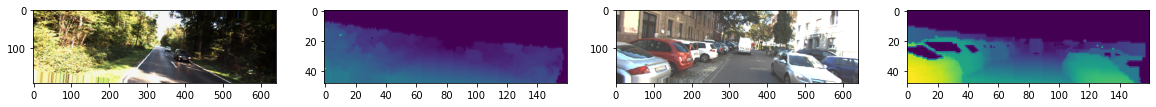

In [8]:
fig= plt.figure(figsize=(20, 20))
for i_f, f in enumerate(val_ds.take(1)):
    for i in range(2):
        plt.subplot(10,4,i_f*2 + 2*i + 1),plt.imshow(f[0][i].numpy());
        plt.subplot(10,4,i_f*2 + 2*i + 2),plt.imshow(f[1][i].numpy());

## The Model Architecture

Eigen et al build a two-stream network for coarse and fine reconstruction.

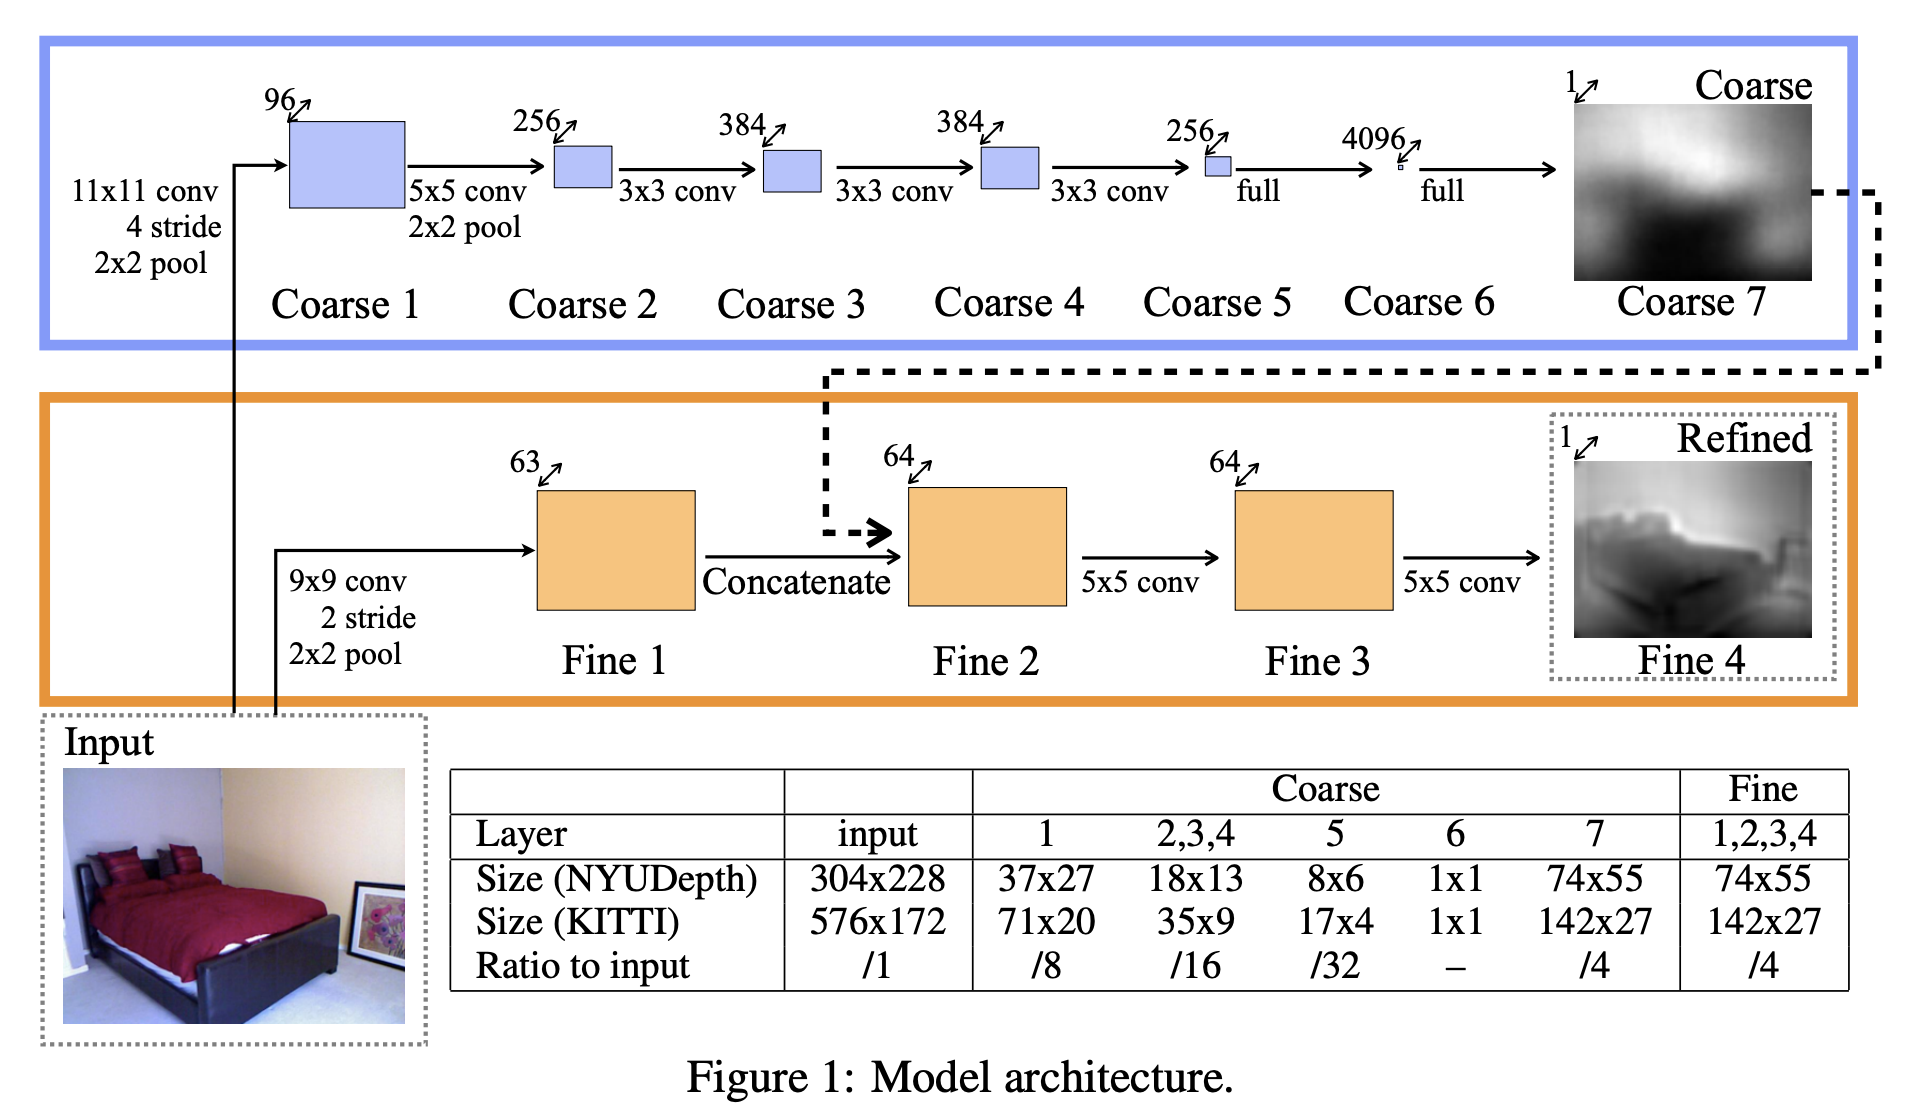

However, the final two fully connected layers introduce an ***enormous*** amount of parameters to optimize. On the order of 100,000,000. 
This is not tractable for training using the time or data we have at hand.

We will therefore replace that part of the network with a convolutional decoder. Using convolutions instead of a fully connected layers reduced the entire model to 3,000,000 parameters, which is well within the realm of tractability.

The architecture is as follows:

**Coarse Stream**
1. Conv 2D, 96 filters, 11x11, stride 4x4 + BatchNorm + ReLU + MaxPool2D (2x2)
2. Conv 2D, 256 filters, 5x5, stride 2x2 + BN + ReLU
3. Conv 2D, 384 filters, 3x3 + BN + ReLu + MaxPool2D (2x2)
4. Conv 2D Transpose, 256 filters, 3x3 + BN + UpSampling2D (2x2) + ReLU
5. Conv 2D Transpose, 96 filters, 3x3 + BN + UpSampling2D (2x2) + ReLU
6. Conv 2D Transpose, 64 filters, 3x3 + BN + UpSampling2D (2x2) + ReLU

**Fine Stream**
1. Conv 2D, 64 filters, 9x9, stride 2x2 + BN + ReLU + MaxPool2D (2x2)
2. Concatenate output from Coarse Stream, e.g number 6 from above (the output of this operation will be \[?, 48, 160, 128\])
3. Conv 2D, 64 filters, 5x5 + BN + ReLU
4. Conv 2D, 64 filters, 5x5 + BN + ReLU
5. Conv 2D, 1 filter, 3x3, **Linear activation** - this is the output predicted depth map at \[?, 48, 160, 1\]
In the next block, implement the convolutional model.

The input and output shapes ([192, 640, 3] and [48, 160] respectively) are fixed for you since they match the input data.

Use `layers.Conv2D`, `layers.MaxPool2D`, `layers.Activation`, `layers.BatchNormalization`, `layers.Conv2DTranspose`, `layers.UpSampling2D`

In [9]:
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, Activation, BatchNormalization
from keras.models import Model
from keras.layers import Conv2D, MaxPool2D, Flatten, Conv2DTranspose, UpSampling2D, Concatenate
import keras.backend as K

In [10]:
def make_model():
    inputs = Input(shape=(192, 640, 3))

    # "Coarse" stream

    # encoder
    c1_Con = Conv2D(96, (11, 11), strides=(4, 4))(inputs)
    c1_Bat = BatchNormalization()(c1_Con)
    c1_Act = Activation('relu')(c1_Bat)
    c1_Poo = MaxPool2D(pool_size=(2, 2))(c1_Act)

    c2_Con = Conv2D(256, (5, 5), strides=(2, 2))(c1_Poo)
    c2_Bat = BatchNormalization()(c2_Con)
    c2_Act = Activation('relu')(c2_Bat)

    c3_Con = Conv2D(384, (3, 3))(c2_Act)
    c3_Bat = BatchNormalization()(c3_Con)
    c3_Act = Activation('relu')(c3_Bat)
    c3_Poo = MaxPool2D(pool_size=(2, 2))(c3_Act)

    # decoder
    c4_Con = Conv2DTranspose(256, (3, 3))(c3_Poo)
    c4_Bat = BatchNormalization()(c4_Con)
    c4_Ups = UpSampling2D(size=(2, 2))(c4_Bat)
    c4_Act = Activation('relu')(c4_Ups)

    c5_Con = Conv2DTranspose(96, (3, 3), padding='same')(c4_Act)
    c5_Bat = BatchNormalization()(c5_Con)
    c5_Ups = UpSampling2D(size=(2, 2))(c5_Bat)
    c5_Act = Activation('relu')(c5_Ups)

    c6_Con = Conv2DTranspose(64, (3, 3), padding='same')(c5_Act)
    c6_Bat = BatchNormalization()(c6_Con)
    c6_Ups = UpSampling2D(size=(2, 2))(c6_Bat)
    c6_Act = Activation('relu')(c6_Ups)

    c_out = c6_Act

    # "Fine" stream

    f1_Con = Conv2D(64, (9, 9), strides=(2, 2), padding='same')(inputs)
    f1_Bat = BatchNormalization()(f1_Con)
    f1_Act = Activation('relu')(f1_Bat)
    f1_Poo = MaxPool2D(pool_size=(2, 2))(f1_Act)

    # # add coarse output in ...

    f2_Con = Concatenate(axis=3)([f1_Poo, c_out])

    f3_Con = Conv2D(64, (5, 5), padding='same')(f2_Con)
    f3_Bat = BatchNormalization()(f3_Con)
    f3_Act = Activation('relu')(f3_Bat)

    f4_Con = Conv2D(64, (5, 5), padding='same')(f3_Act)
    f4_Bat = BatchNormalization()(f4_Con)
    f4_Act = Activation('relu')(f4_Bat)

    f5_Con = Conv2D(1, (3, 3), activation='linear', padding='same')(f4_Act)

    outputs = f5_Con # ...

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss='categorial_crossentropy', optimizer='sgd', metrics=['accuracy'])


    return Model(inputs, outputs)

Verify that your model is the way you expect it, and that there are no errors with tensor shapes:

In [11]:
model = make_model()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 192, 640, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 46, 158, 96)  34944       input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 46, 158, 96)  384         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 46, 158, 96)  0           batch_normalization[0][0]        
____________________________________________________________________________________________

## Loss function

Loss function from the Eigen et al. 2015 paper:

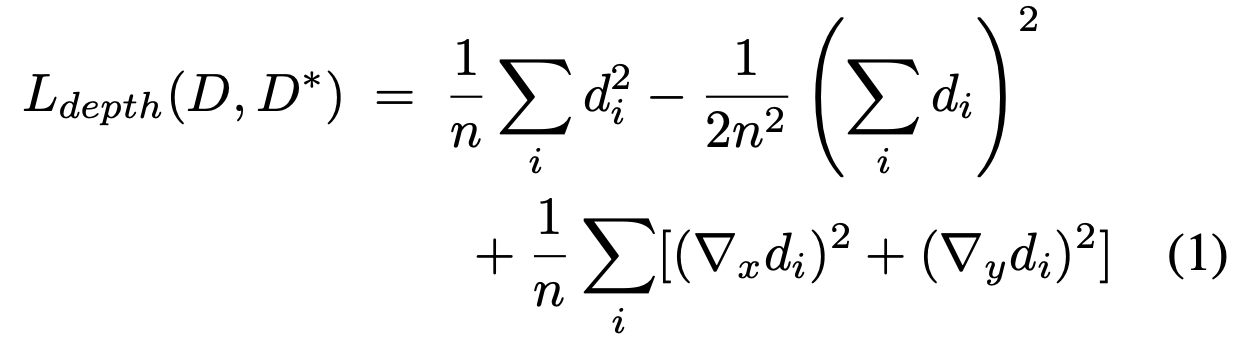

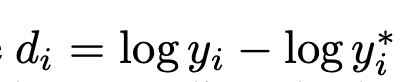

Note that we only need to "actively" take the log of the **ground truth** depth map, since the network will already try to predict the log-depth, so we can compare **directly** the `tf.math.log(y_true)` vs `y_pred` (no need to take the log of `y_pred`).

Also note that Eigen et al say "the sums are over valid pixels `i`, and `n` is the number of valid pixels (we mask out pixels where the ground truth is missing).

To that end use the `tf.where()` and `tf.greater()` functions to only calculate the logarithm in pixels with valid values (e.g. > 0). Logarithm is `-inf` on 0 values, which will derail our calculations.

You can use the `tf.math.count_nonzero` function to calculate `n` directly.

Start by calculating `d` in terms of `y_pred, y_true`, and use it with `tf.reduce_sum` and `tf.square` to get the calculations you require.

In [76]:
def eigen_2015_loss(y_true, y_pred):
    y_true = tf.cast(y_true, dtype=float)
    y_pred = tf.cast(y_pred, dtype=float)
    
    # Calculate d from y_true and y_pred
    # d = ...
    d = tf.where(tf.greater(y_true, 0), tf.math.log(y_true) - y_pred, tf.zeros_like(y_true))
    valid = tf.where(tf.greater(y_true, 0), True, False)
    
    # Get `n` from `y_true`. Don't forget to tf.cast to tf.float32
    # n = ...
    n = tf.math.count_nonzero(y_true, axis=[1, 2, 3])
    n = tf.cast(n, float)
    
    # Calculate data term
    # data_term = ...
    data_term = tf.reduce_sum(tf.square(d), axis=[1, 2, 3])
    data_term = tf.divide(data_term, n)
    
    # Calculate direction term
    # direction_term = ...
    direction_term = tf.reduce_sum(d, axis=[1, 2, 3])
    direction_term = tf.square(direction_term)
    direction_term = -tf.divide(direction_term, 2 * tf.square(n))
    # Calculate gradient matching term
    # matching_term = ...
    dy,dx=tf.image.image_gradients(d)
    grad=tf.square(dy)+tf.square(dx)
    D_sum3=tf.math.reduce_sum(grad)
    matching_term=(1/n)*D_sum3
    return data_term + direction_term + matching_term

In [77]:
for_evaluations = next(iter(labeled_ds.take(2)))
#predictions = model.predict(for_evaluations[0])
predictions = next(iter(val_ds.take(2)))

relative_depth_threshold_metric(for_evaluations, predictions, 0.25)

InvalidArgumentError: Shapes of all inputs must match: values[0].shape = [32,192,640,3] != values[1].shape = [32,48,160] [Op:Pack] name: x

In [10]:
def eigen_2015_loss(y_true, y_pred):
    y_true = tf.cast(y_true, dtype=float)
    y_pred = tf.cast(y_pred, dtype=float)
    
    # Calculate d from y_true and y_pred
    # d = ...
    d = tf.where(tf.greater(y_true, 0), tf.math.log(y_true) - y_pred, tf.zeros_like(y_true))
    valid = tf.where(tf.greater(y_true, 0), True, False)
    
    # Get `n` from `y_true`. Don't forget to tf.cast to tf.float32
    # n = ...
    n = tf.math.count_nonzero(y_true)
    n = tf.cast(n, float)
    
    # Calculate data term
    # data_term = ...
    data_term = tf.reduce_sum(tf.square(d))
    data_term = tf.divide(data_term, n)
    
    # Calculate direction term
    # direction_term = ...
    direction_term = tf.reduce_sum(d)
    direction_term = tf.square(direction_term)
    direction_term = -tf.divide(direction_term, 2 * tf.square(n))
    
   # Calculate gradient matching term
    # matching_term = ...
    d_di = d[:,1:,:] - d[:,:-1,:]
    d_dj = d[:,:,1:] - d[:,:,:-1]
    valid_di = tf.cast(tf.logical_and(valid[:,1:,:], valid[:,:-1,:]), float)
    valid_dj = tf.cast(tf.logical_and(valid[:,:,1:], valid[:,:,:-1]), float)
    ni = tf.reduce_sum(valid_di)
    nj = tf.reduce_sum(valid_dj)
    matching_term = tf.divide(tf.reduce_sum(valid_di * tf.square(d_di)), ni) + tf.divide(tf.reduce_sum(valid_dj * tf.square(d_dj)), nj)

    return data_term + direction_term + matching_term

In [11]:
for_evaluations = next(iter(val_ds.take(1)))
#predictions = model.predict(for_evaluations[0])
predictions = next(iter(val_ds.take(1)))
ll=eigen_2015_loss(for_evaluations[1], predictions[1])
print(ll)

tf.Tensor(752.0601, shape=(), dtype=float32)


## Training the model

We will train the model with the `keras.optimizers.Adam` optimizer. 
* Learning rate = `1e-3`
* Number of Epochs = 150
* Steps per epoch = 20
Compile your model with `model.compile(...)`, and add the custom loss function you've created `eigen_2015_loss`.

Write a callback using `keras.callbacks.ModelCheckpoint` to monitor the `val_loss` metric, and `save_best_only=True`. This will create a saved point for us later to load and test on our data.

Don't forget to supply the validation data `val_ds` in `validation_data` in the `model.fit()` function.

In [12]:
epochs = 150
learning_rate = 1e-3

# make model ...
model = make_model()

# compile with keras.optimizers.Adam and eigen_2015_loss
# ...
model.compile(
optimizer=keras.optimizers.Adam(learning_rate),
loss=eigen_2015_loss
)
callbacks = [
    # ...
    keras.callbacks.ModelCheckpoint("save_best.h5",monitor="val_loss",save_best_only=True),
]

Call the `.fit()` function of the model with the `labeled_ds` and `val_ds` datasets.
This may take ~20-30 minutes to complete. Select a GPU runtime. Training on CPU will be too slow, and may take hours to finish.

In [13]:
history = model.fit(
    # ...
    labeled_ds,
    epochs=150,
    steps_per_epoch=20,
    callbacks=callbacks,
    validation_data=val_ds,
    validation_steps=1,
    validation_batch_size=32,
)

Epoch 1/50
50/50 [==============================] - 374s 7s/step - loss: 0.9828 - val_loss: 6.3295
Epoch 2/50
50/50 [==============================] - 434s 9s/step - loss: 0.6034 - val_loss: 0.9960
Epoch 3/50
50/50 [==============================] - 392s 8s/step - loss: 0.5775 - val_loss: 0.7249
Epoch 4/50
50/50 [==============================] - 388s 8s/step - loss: 0.5702 - val_loss: 0.9488
Epoch 5/50
50/50 [==============================] - 388s 8s/step - loss: 0.5466 - val_loss: 0.5753
Epoch 6/50
50/50 [==============================] - 389s 8s/step - loss: 0.5342 - val_loss: 0.5040
Epoch 7/50
50/50 [==============================] - 388s 8s/step - loss: 0.5201 - val_loss: 0.5661
Epoch 8/50
50/50 [==============================] - 390s 8s/step - loss: 0.5134 - val_loss: 0.6191
Epoch 9/50
50/50 [==============================] - 390s 8s/step - loss: 0.5014 - val_loss: 0.7097
Epoch 10/50
50/50 [==============================] - 390s 8s/step - loss: 0.4851 - val_loss: 0.5735
Epoch 11/

Visualize the learning curves

In [2]:
pd.DataFrame(history.history).plot(figsize=(8,5), logy=True)
plt.show()

NameError: name 'history' is not defined

### Model Training Matters

You should see a consistent decrease in the loss, up to a point. The validation loss should follow the training loss. If they diverge - it's most likely a sign of overfitting and training should be stopped.

If your model is making no progress in learning and is stuck in a plateau at a high loss value (e.g. > 1.0), examine your loss function carefully and disable all but the "data term". Return to your model architecture and make sure the activations are correct (e.g. a "linear" activation for the final prediction layer). You may try also to disable the "Fine" stream and only keep the "Coarse" stream, and see if that allows the network to converge.

### Visualize prediction results

In [12]:
# restore the best model
model.load_weights('save_best.h5')

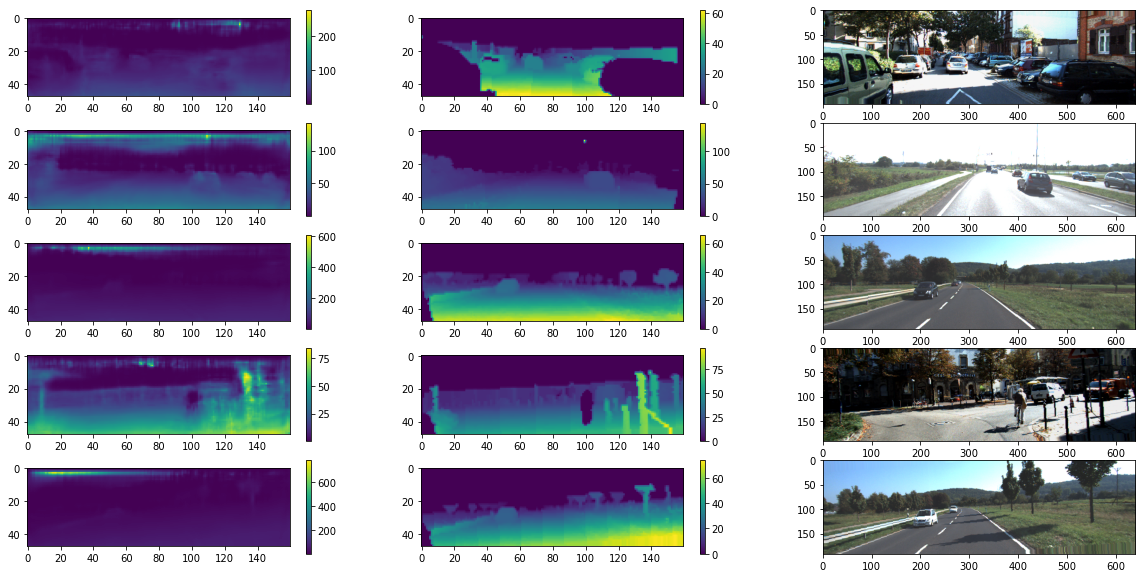

In [13]:
plt.figure(figsize=(20,10))
for_test = next(iter(val_ds.take(1)))
for i in range(5):
    plt.subplot(5,3,3*i + 1),plt.imshow(np.exp(model.predict(for_test[0])[i,:,:,0])),plt.colorbar();
    plt.subplot(5,3,3*i + 2),plt.imshow(for_test[1][i].numpy()), plt.colorbar();
    plt.subplot(5,3,3*i + 3),plt.imshow(for_test[0][i].numpy());

## Evaluation metrics

Since KITTI do not provide ground truth on their test sets, we can only use it for qualitative impressions. However we can calculate some evaluation metrics mentioned in the paper over the validation set.

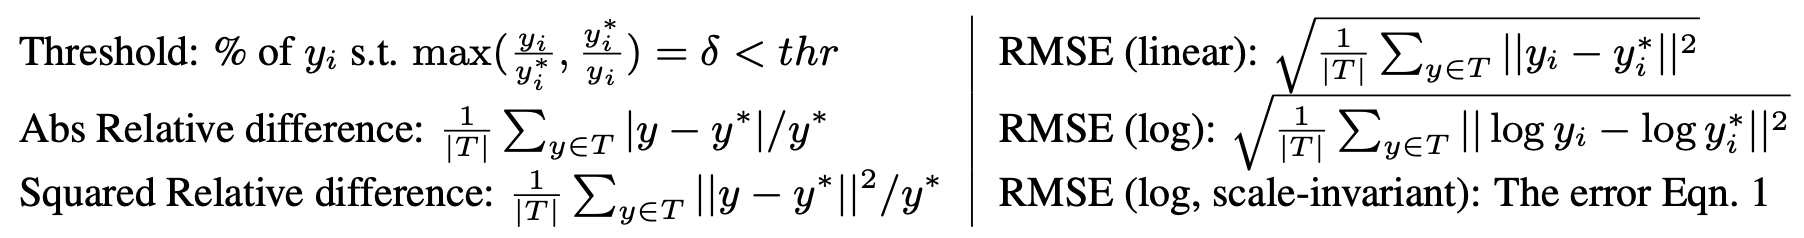

Implement the relative depth threshold and absolute relative difference measures. The RSME (linear and log) have pre-made implementations.

Some functions you will find useful: `tf.less` and `tf.greater`, `tf.reduce_sum` and `tf.reduce_mean`, `tf.ones_like`, `tf.zeros_like`, `tf.where`, `tf.math.maximum`.

In [35]:
def relative_depth_threshold_metric(y_true, y_pred, delta_threshold):
    # calculate the max relative depths (delta), e.g. max(y_true / y_pred, y_pred / y_true)
    # and then count how many are over the `delta_threshold`
    # ...
    y_true = tf.cast(y_true, dtype=float)
    y_pred = tf.cast(y_pred, dtype=float)
    delta_threshold= tf.cast(delta_threshold, dtype=float)
    condition=tf.less(tf.math.maximum(tf.divide(y_true, y_pred),tf.divide(y_pred, y_true)), delta_threshold)
    count= tf.where(condition, tf.ones_like(y_true), tf.zeros_like(y_true))
    n = tf.math.count_nonzero(count)
    a = tf.math.count_nonzero(y_true)
    print('%.2f%%' % (n/a * 100))
    return None

def absolute_relative_difference_metric(y_true, y_pred):
    # calculate the mean absolute difference, e.g. mean(abs(y_pred - y_true))
    # ...
    y_true = tf.cast(y_true, dtype=float)
    y_pred = tf.cast(y_pred, dtype=float)
    ab=tf.abs(y_pred-y_true)/y_pred
    mean=tf.reduce_mean(ab)
    print(mean)
    
    return None

Take a batch from the validation set for evaluation:

In [36]:
for_evaluations = next(iter(val_ds.take(1)))
predictions = model.predict(for_evaluations[0])

Run the evaluation methods:

In [37]:
relative_depth_threshold_metric(for_evaluations[1], np.exp(predictions[:,:,:,0]), 1.25)

80.87%


In [38]:
absolute_relative_difference_metric(for_evaluations[1], np.exp(predictions[:,:,:,0]))

AttributeError: module 'tensorflow' has no attribute 'Session'

Unseen data without ground truth:

In [22]:
list_ds_test = tf.data.Dataset.list_files('testing/image_2/*_10.png')
def process_path_test(file_path):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_png(image)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [192, 640])

    return image

test_ds = list_ds_test.map(process_path_test)
test_ds = test_ds.batch(5)

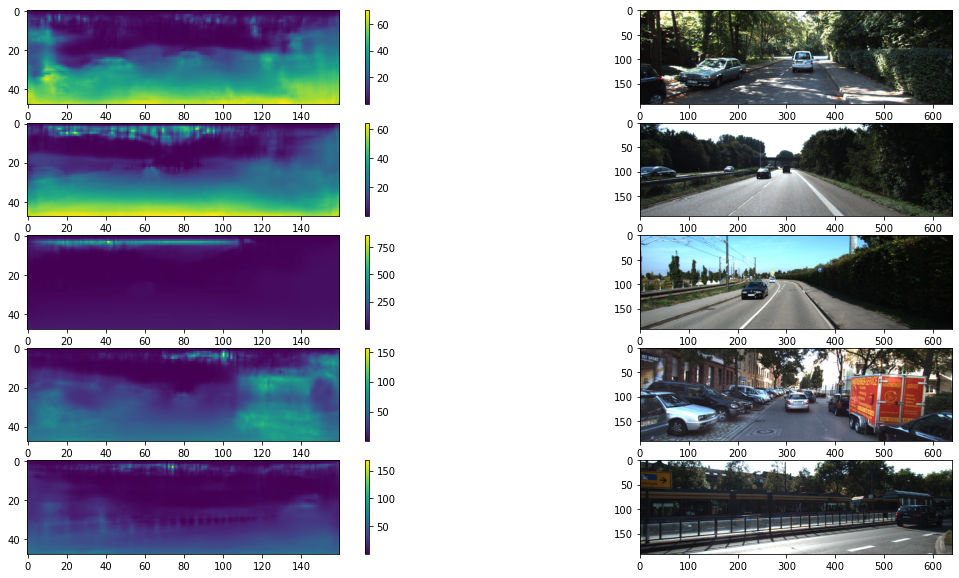

In [22]:
plt.figure(figsize=(20,10))
for_test = next(iter(test_ds.take(1)))
for i in range(5):
    plt.subplot(5,2,2*i + 1),plt.imshow(np.exp(model.predict(for_test)[i,:,:,0])),plt.colorbar();
    plt.subplot(5,2,2*i + 2),plt.imshow(for_test[i].numpy());

# Conclusion

This exercise showed you how to implement an upgraded version of the important work from Eigen et al. It is a simple approach but quite powerful if it's built and trained correctly.

Your next steps in depth reconstruction can be to implement more complex methodds that achieve higher accuracy and higher resolution predictions.